In [1]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

(35.0, 50.0)

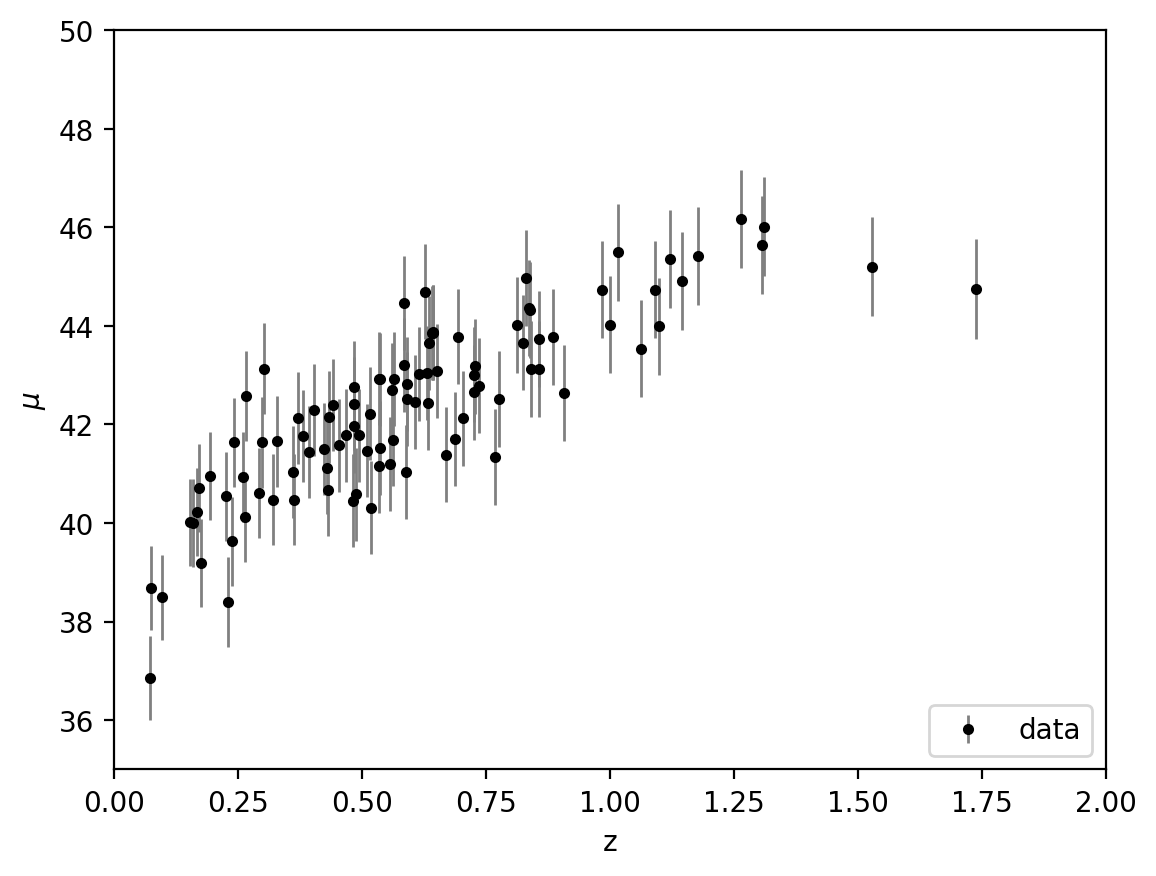

In [2]:
from astroML.datasets import generate_mu_z
from astropy.cosmology import LambdaCDM
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

C:\Users\Admin\anaconda3\envs\pymc_env\Lib\site-packages\astropy\cosmology\flrw\base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


(35.0, 50.0)

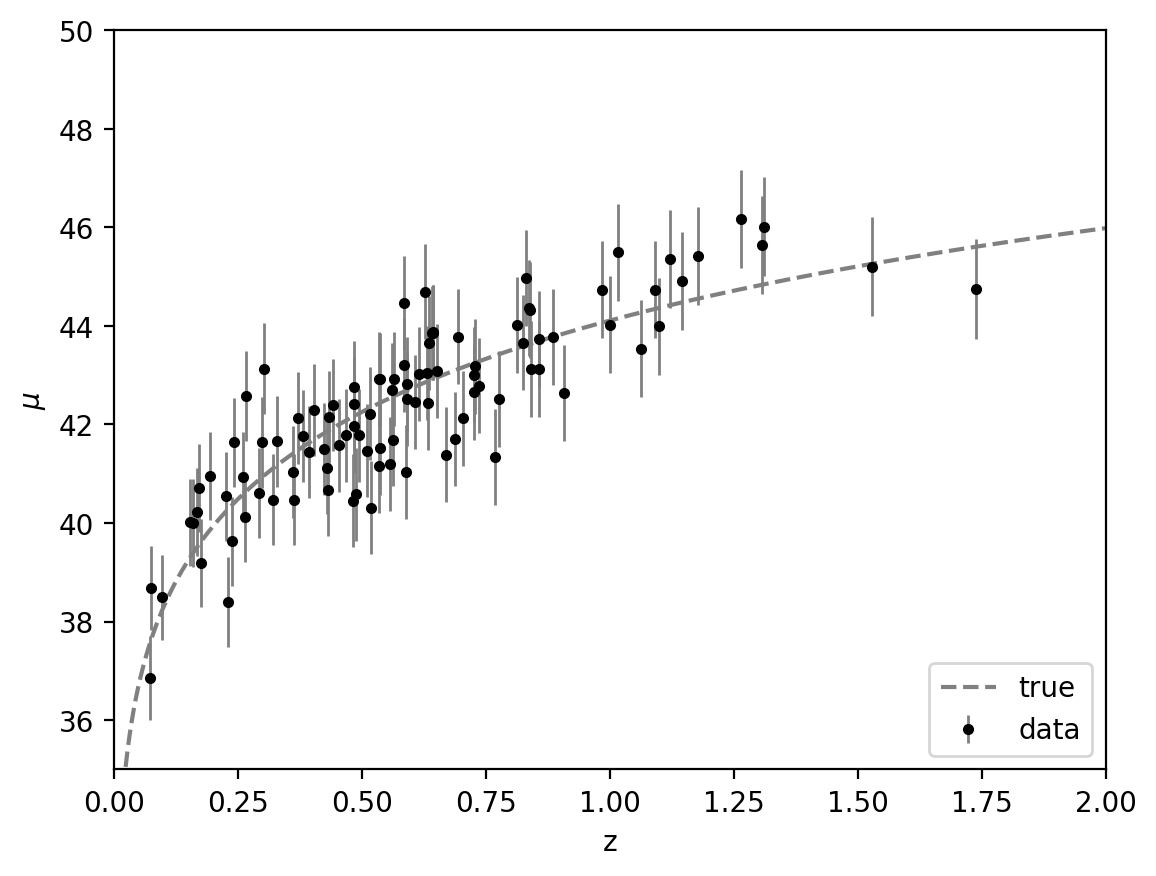

In [3]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
X_new = np.linspace(0,2,1000)
mu_true = cosmo.distmod(X_new)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(X_new, mu_true, '--', c='gray',label='true')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Linear regression

In [4]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(z_sample.reshape(-1,1),  mu_sample.reshape(-1,1), sample_weight=(1/(dmu**2)))

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)
y_pred_lin = lin_reg.predict(X_new.reshape(-1, 1))

[39.48384602] [[4.76438865]]


(35.0, 50.0)

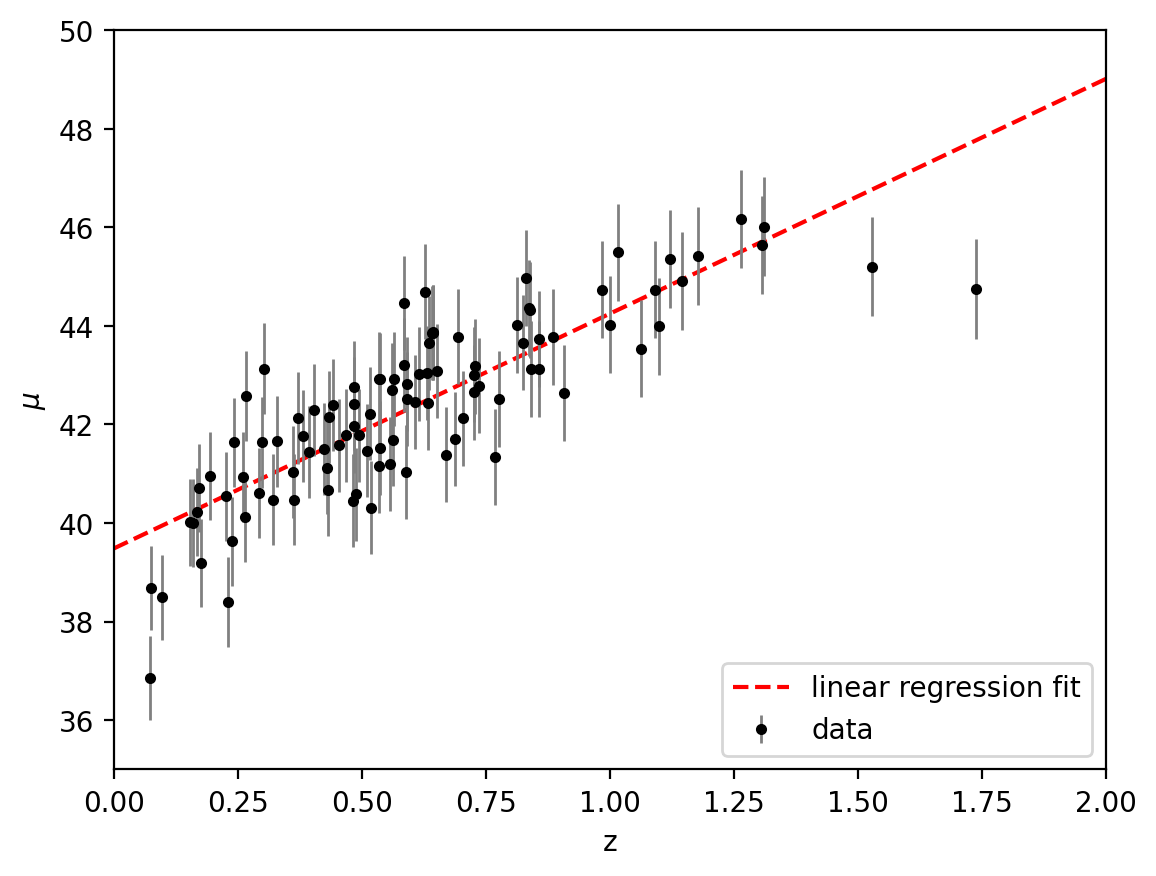

In [5]:
plt.plot(X_new, y_pred_lin, '--r', label = 'linear regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Polynomial regression

In [6]:
from astroML.linear_model import PolynomialRegression

degree = 3
model = PolynomialRegression(degree) # fit 3rd degree polynomial
model.fit(z_sample.reshape(-1,1),  mu_sample)

y_pred_poly = model.predict(X_new.reshape(-1,1))
n_constraints = degree + 1

print(model.coef_)

[38.49130243  8.23905057 -2.20391808 -0.15168104]


C:\Users\Admin\anaconda3\envs\pymc_env\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


(35.0, 50.0)

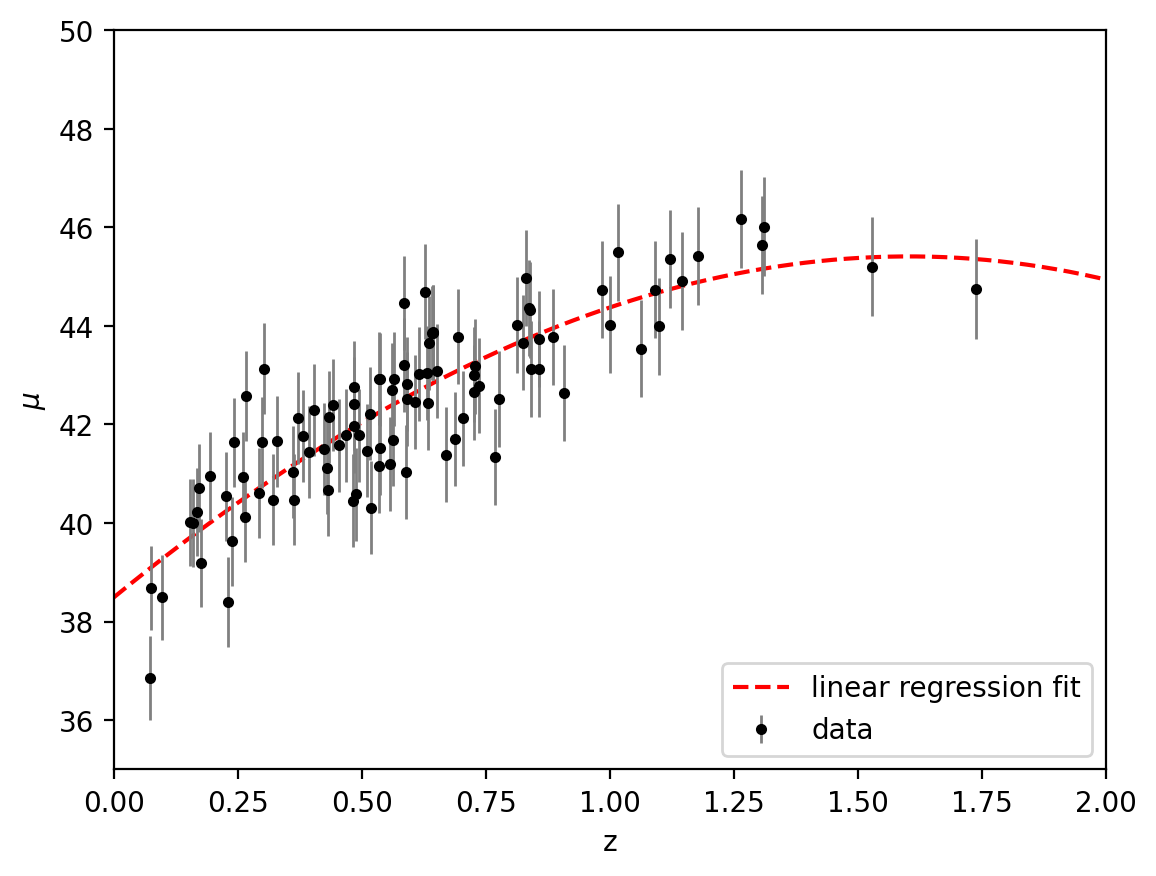

In [7]:
plt.plot(X_new, y_pred_poly, '--r', label = 'linear regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

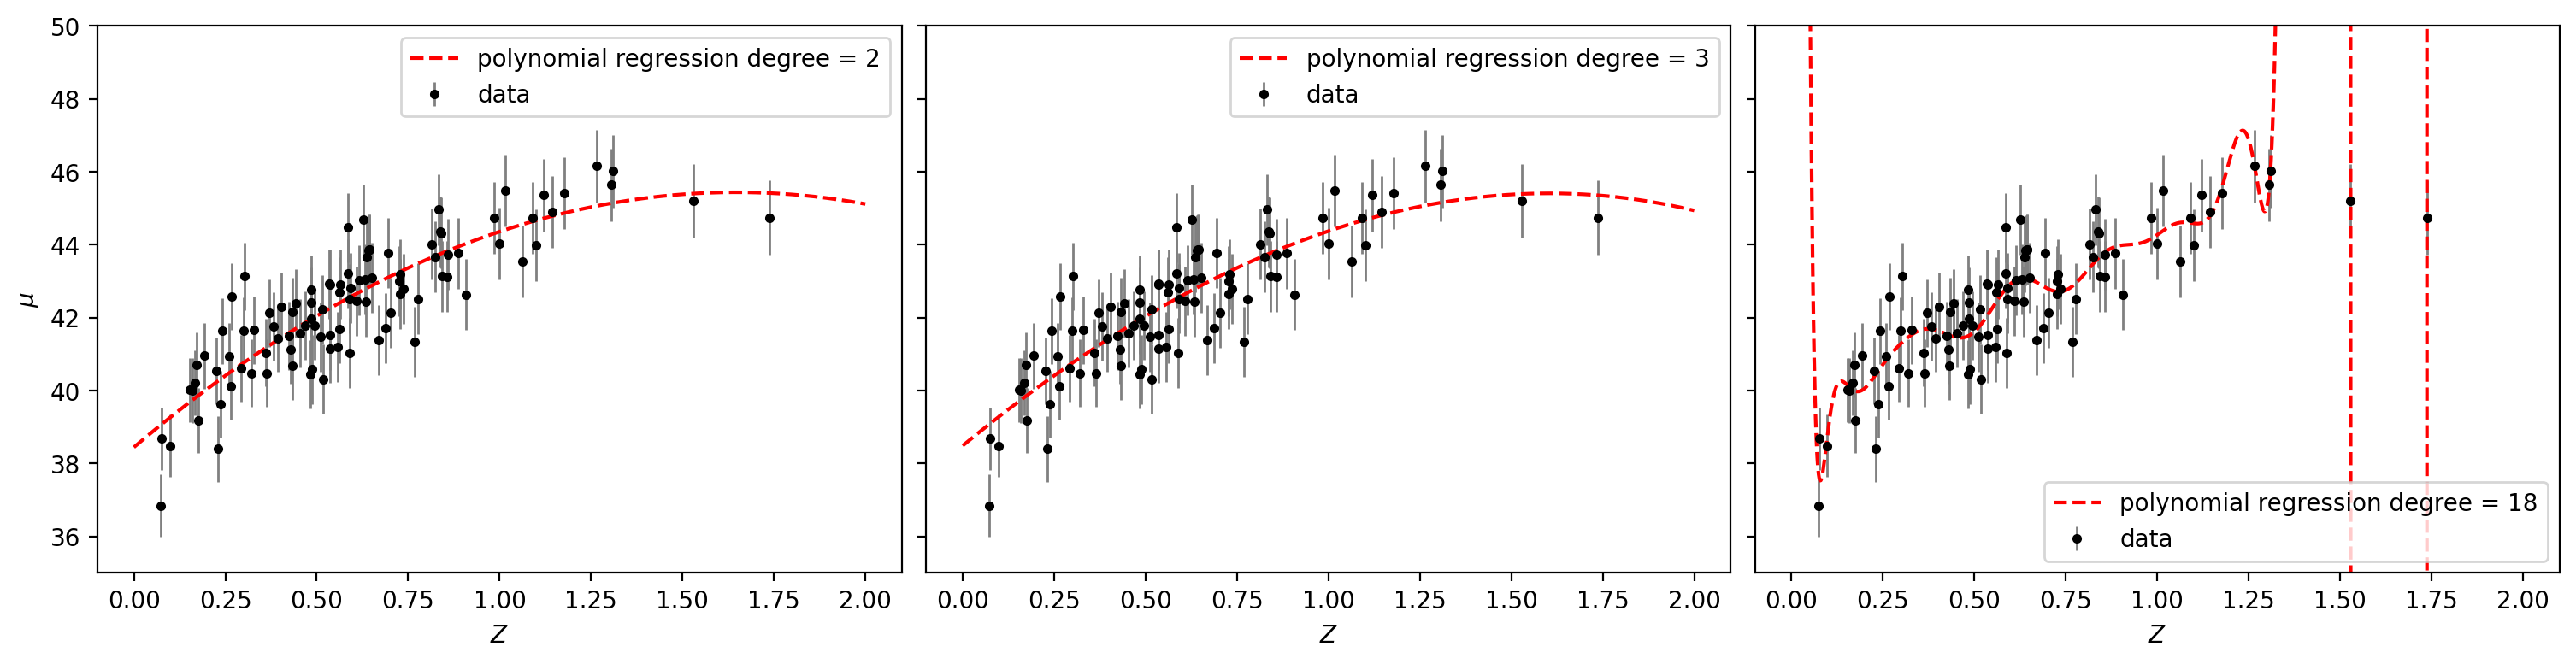

In [8]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, degree in enumerate([2, 3, 18]):  #Try 2nd, 3rd and 19th order
    ax = fig.add_subplot(131 + i)
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')

    model = PolynomialRegression(degree) # fit 3rd degree polynomial
    model.fit(z_sample.reshape(-1,1),  mu_sample)

    y_pred_poly = model.predict(X_new.reshape(-1,1))

    ax.plot(X_new, y_pred_poly, '--r', label = 'polynomial regression degree = '+ str(degree))
    
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$\mu$')

    ax.set_ylim(35,50)
    ax.set_xlabel('$Z$')
    ax.legend()
    
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

z_train, z_cv, mu_train, mu_cv = train_test_split(z_sample, mu_sample, test_size=0.3, random_state=42)

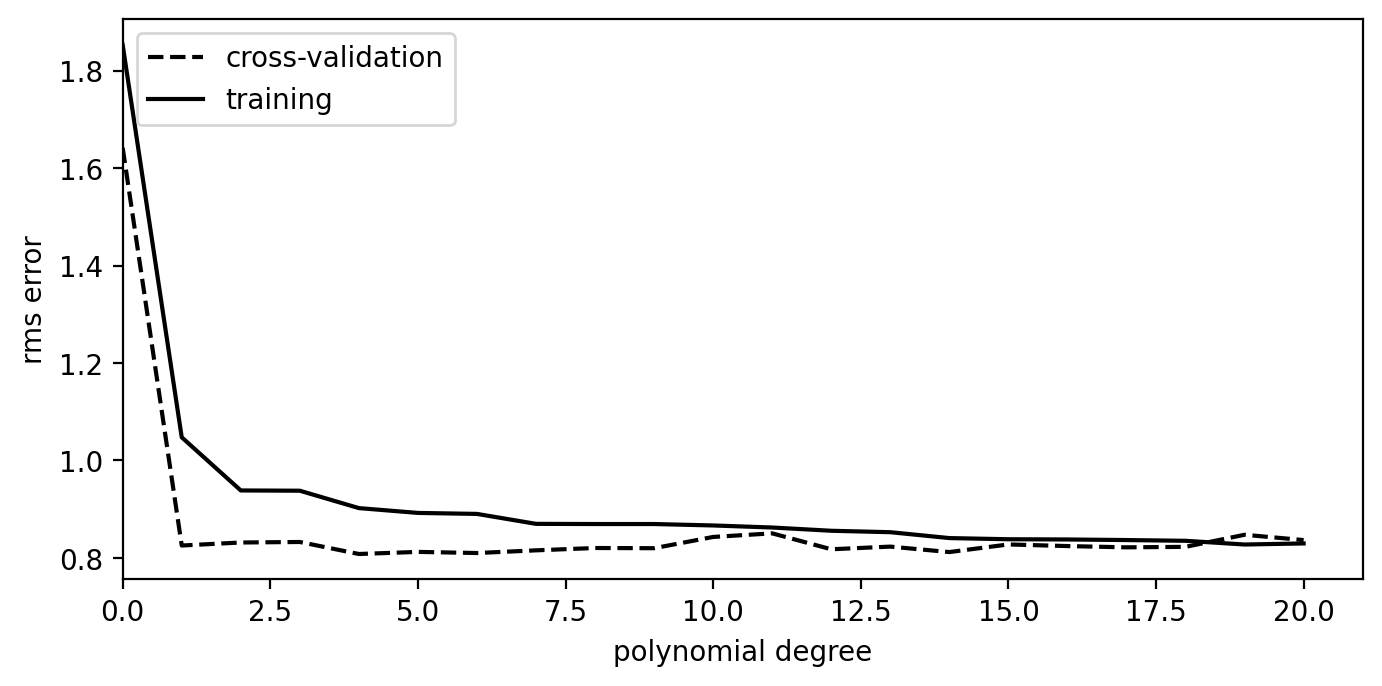

4


In [10]:
degree = np.arange(0, 21)

training_err = np.zeros(degree.shape)
crossval_err = np.zeros(degree.shape)

fig = plt.figure(figsize=(8, 8))
for d in degree:
    
    model = PolynomialRegression(d)
    model.fit(z_train.reshape(-1,1),  mu_train)

    y_train = model.predict(z_train.reshape(-1,1))
    y_cv = model.predict(z_cv.reshape(-1,1))
    
    training_err[d] = np.sqrt(np.sum((mu_train - y_train) ** 2)  / len(mu_train))
    crossval_err[d] = np.sqrt(np.sum((mu_cv - y_cv) ** 2) / len(mu_cv))

ax = fig.add_subplot(211)
ax.plot(degree, crossval_err, '--k', label='cross-validation')
ax.plot(degree, training_err, '-k', label='training')

ax.set_xlim(0, 21)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

plt.show()

print(np.argmin(crossval_err))

In [11]:
degree = np.arange(0, 21)
K=10

grid = GridSearchCV(PolynomialRegression(), {'degree': degree}, scoring = 'neg_root_mean_squared_error', cv= K) # Try each bandwidth with K-folds
grid.fit(z_sample[:,np.newaxis], mu_sample)
d_opt = grid.best_params_
print(d_opt)

{'degree': 5}


# Basis function regression

In [12]:
#Basis function regression looks like this
from astroML.linear_model import BasisFunctionRegression

# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(min(z_sample),max(z_sample),10)[:, None]
# widths of these Gaussians
sigma_test = 0.1

model = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=sigma_test)
model.fit(z_sample.reshape(-1,1), mu_sample, dmu)

y_pred_basis = model.predict(X_new.reshape(-1,1))
print(model.coef_)

[20.8016672   3.5091414   3.7469782   3.8019351   4.11376634  4.13199757
  4.36895315  4.47850271  4.80974925  4.31792133  5.21531913]


(35.0, 50.0)

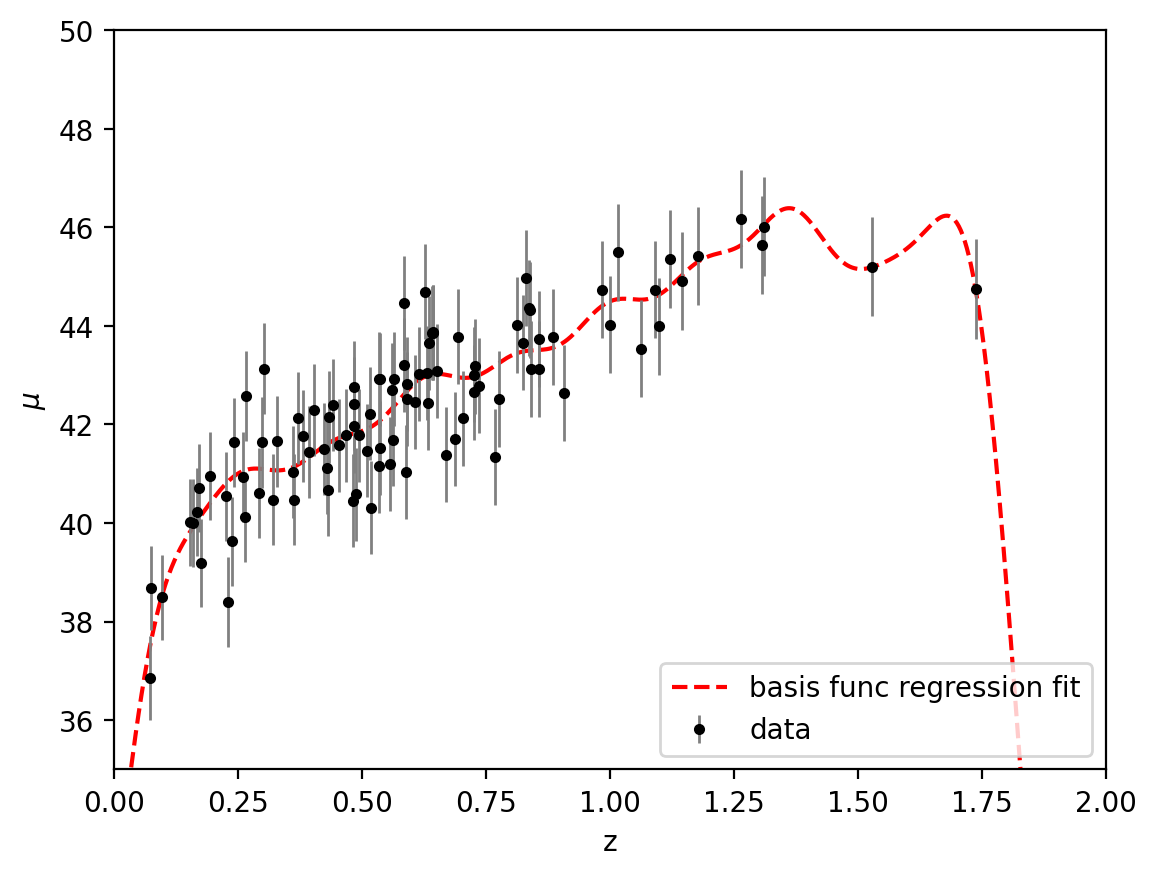

In [13]:
plt.plot(X_new, y_pred_basis, '--r', label = 'basis func regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

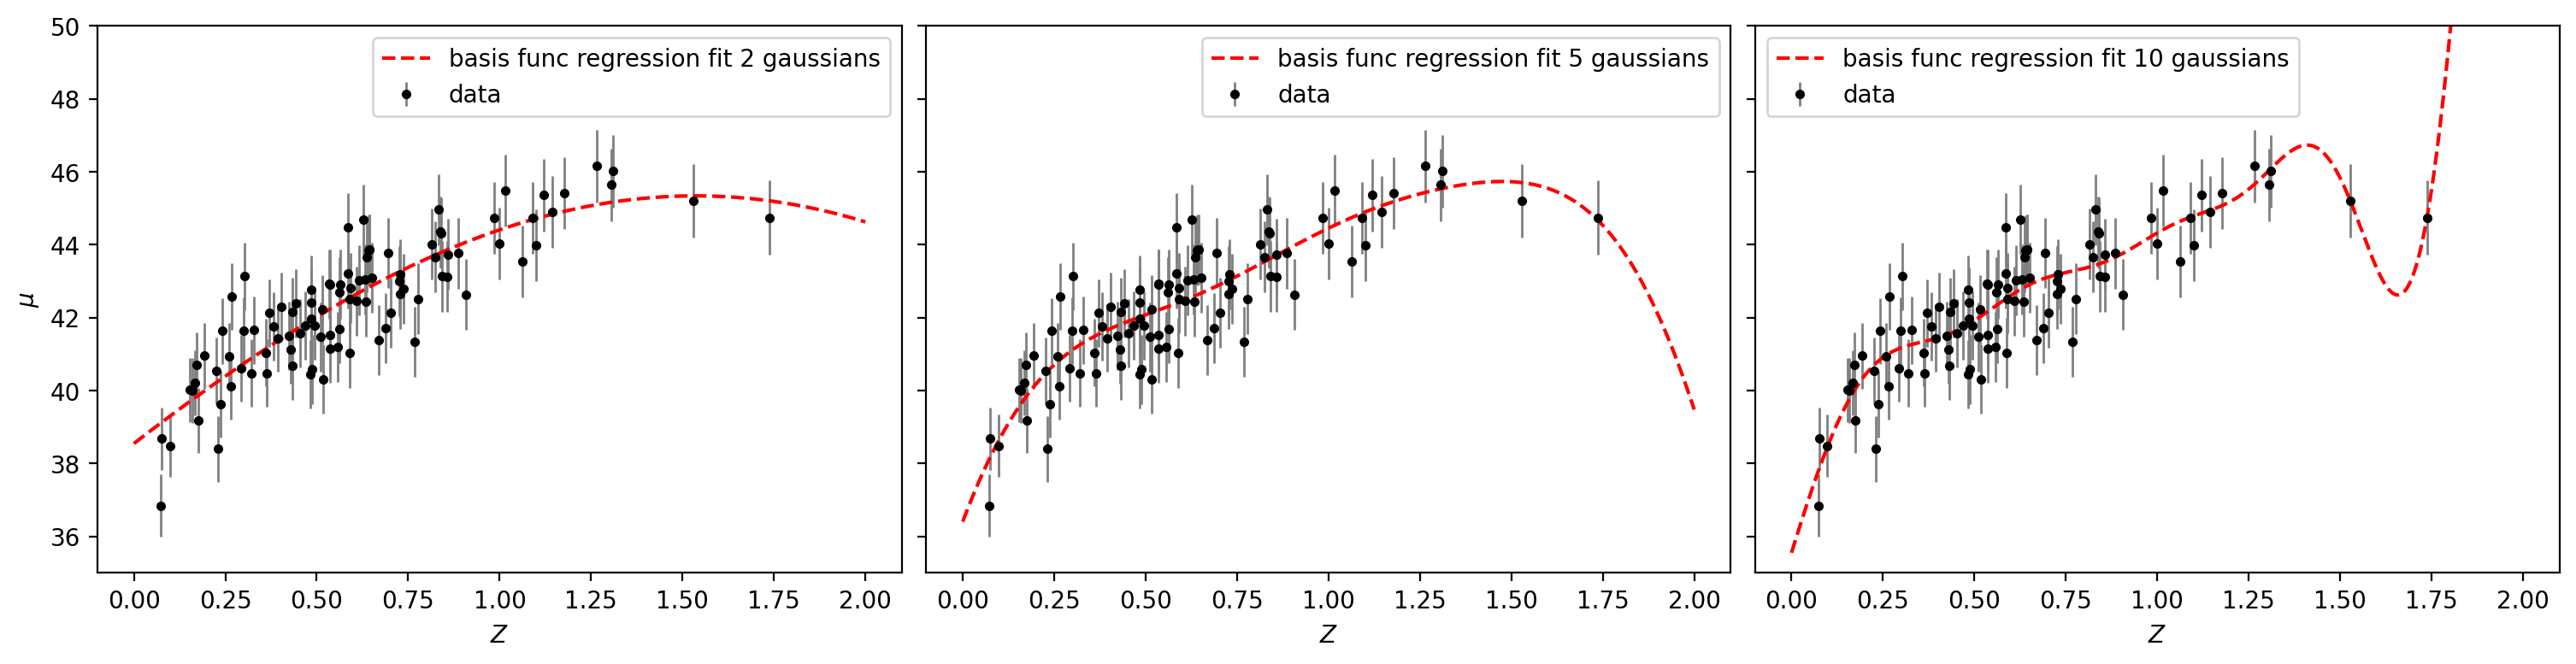

In [14]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, n in enumerate([2, 5, 10]):
    ax = fig.add_subplot(131 + i)
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')

    X_gridtest = np.linspace(0,2,n)[:, None]
    
    sigma_test = 1.0 * (X_gridtest[1] - X_gridtest[0])

    model = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=sigma_test)
    model.fit(z_sample.reshape(-1,1), mu_sample, dmu)

    y_pred_basis = model.predict(X_new.reshape(-1,1))

    plt.plot(X_new, y_pred_basis, '--r', label = 'basis func regression fit '+ str(n) + ' gaussians')
    
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$\mu$')

    ax.set_ylim(35,50)
    ax.set_xlabel('$Z$')
    ax.legend()
    
plt.show()

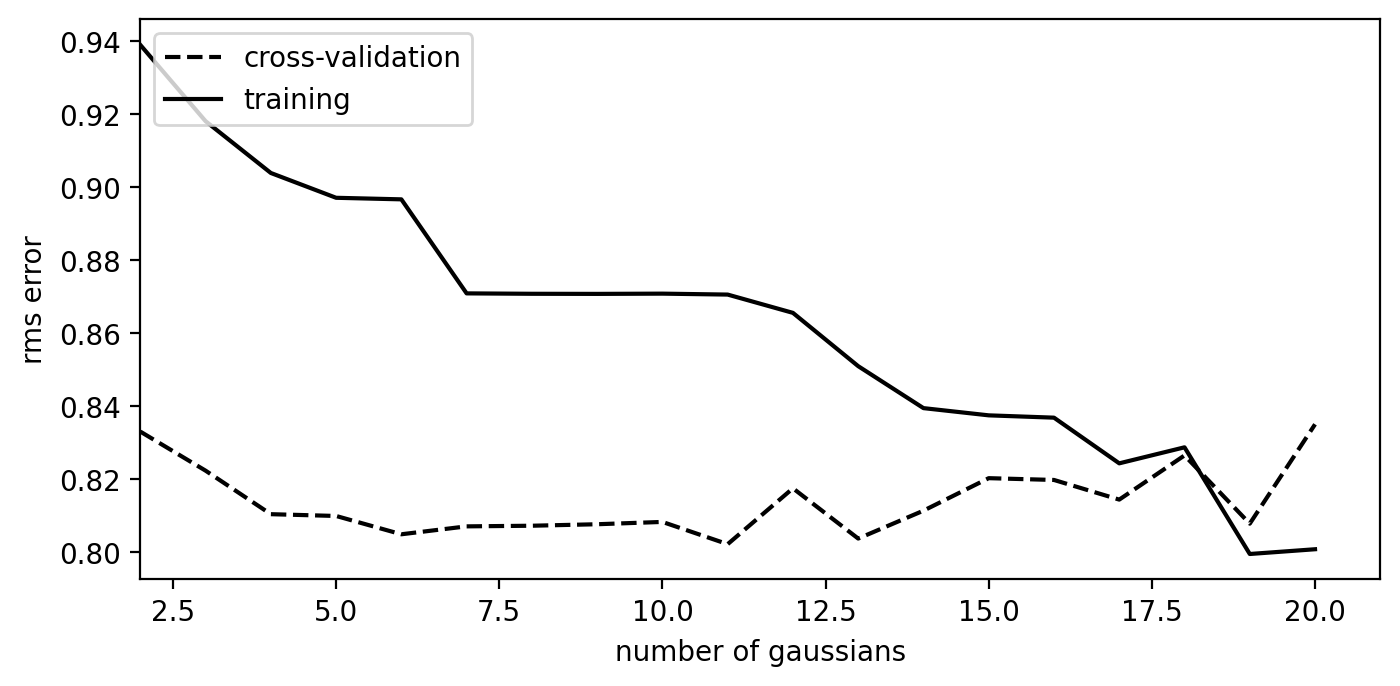

9


In [15]:
n_gauss = np.arange(2, 21)

training_err = np.zeros(n_gauss.shape)
crossval_err = np.zeros(n_gauss.shape)

fig = plt.figure(figsize=(8, 8))
for n in n_gauss:
    
    X_gridtest = np.linspace(0,2,n)[:, None]
    
    sigma_test = 1.0 * (X_gridtest[1] - X_gridtest[0])

    model = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=sigma_test)
    model.fit(z_train.reshape(-1,1),  mu_train)

    y_train = model.predict(z_train.reshape(-1,1))
    y_cv = model.predict(z_cv.reshape(-1,1))
    
    training_err[n-2] = np.sqrt(np.sum((mu_train - y_train) ** 2)  / len(mu_train))
    crossval_err[n-2] = np.sqrt(np.sum((mu_cv - y_cv) ** 2) / len(mu_cv))

ax = fig.add_subplot(211)
ax.plot(n_gauss, crossval_err, '--k', label='cross-validation')
ax.plot(n_gauss, training_err, '-k', label='training')

ax.set_xlim(2, 21)
ax.set_xlabel('number of gaussians')
ax.set_ylabel('rms error')
ax.legend(loc=2)

plt.show()

print(np.argmin(crossval_err))

In [16]:
#n_gauss = np.arange(2, 21)
#K=10

#grid = GridSearchCV(BasisFunctionRegression(), {'kernel':['gaussian'],'mu': X_gridtest, 'sigma'= sigma_test }, scoring = 'neg_root_mean_squared_error', cv= K) # Try each bandwidth with K-folds
#grid.fit(z_sample[:,np.newaxis], mu_sample)
#h_opt = grid.best_params_
#print(h_opt)

# Kernel regression

In [17]:
from astroML.linear_model import NadarayaWatson

model = NadarayaWatson(kernel='gaussian', h=0.05)
model.fit(z_sample.reshape(-1,1),mu_sample)

y_pred_kernel = model.predict(X_new.reshape(-1,1))

(35.0, 50.0)

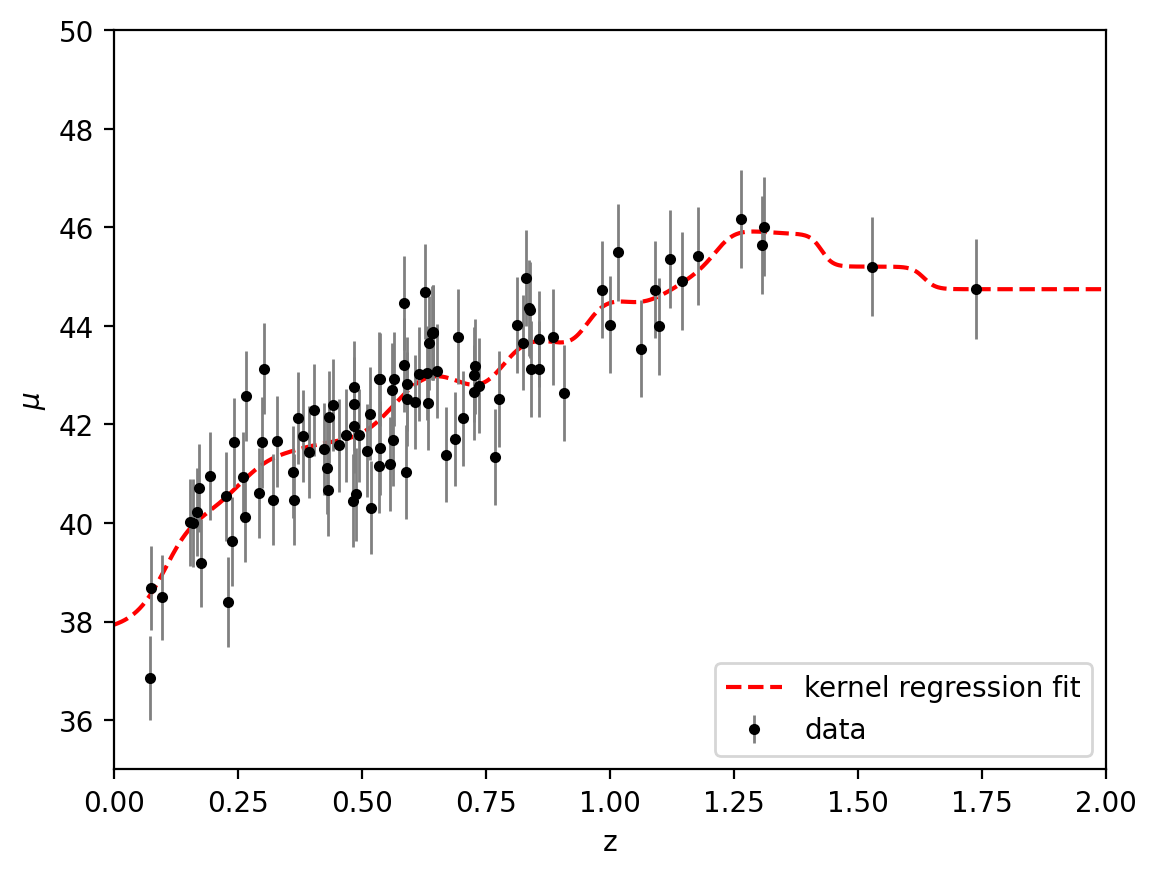

In [18]:
plt.plot(X_new, y_pred_kernel, '--r', label = 'kernel regression fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

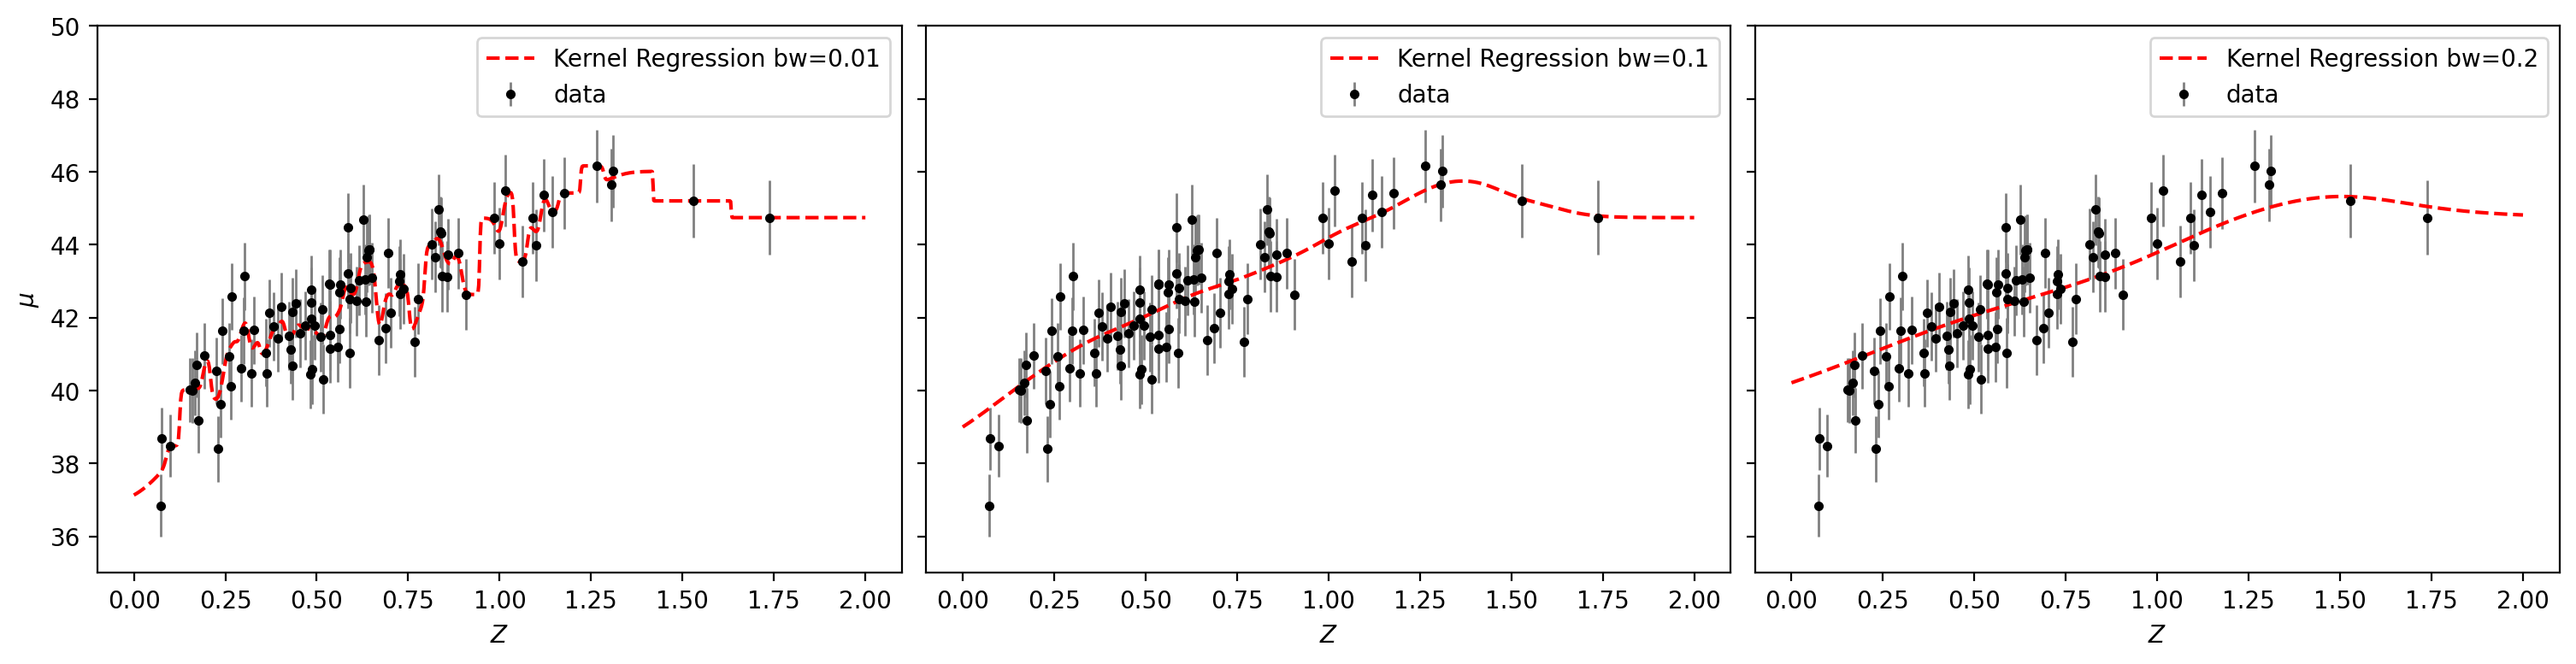

In [19]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, bw in enumerate([0.01, 0.1, 0.2]):
    ax = fig.add_subplot(131 + i)
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label = 'data')

    model = NadarayaWatson(kernel='gaussian', h=bw)

    model.fit(z_sample.reshape(-1,1),mu_sample)

    y_pred_kernel = model.predict(X_new.reshape(-1,1))
    
    ax.plot(X_new, y_pred_kernel, '--r', label='Kernel Regression bw='+str(bw))
    
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$\mu$')

    ax.set_ylim(35,50)
    ax.set_xlabel('$Z$')
    ax.legend()
    
plt.show()

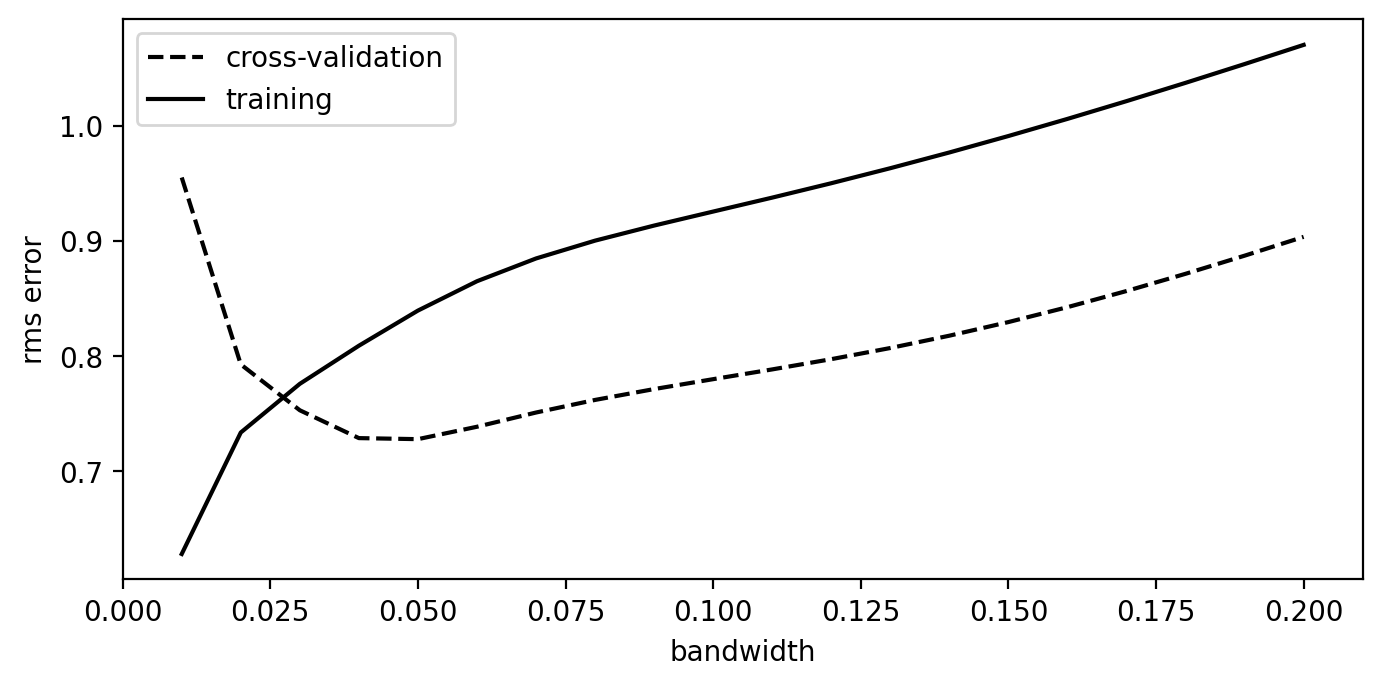

0.05


In [20]:
bandwidth = np.linspace(0.01, 0.2, 20)

training_err = np.zeros(bandwidth.shape)
crossval_err = np.zeros(bandwidth.shape)

fig = plt.figure(figsize=(8, 8))
for i, bw in enumerate(bandwidth):
    
    model = NadarayaWatson(kernel='gaussian', h=bw)
    model.fit(z_train.reshape(-1,1),  mu_train)

    y_train = model.predict(z_train.reshape(-1,1))
    y_cv = model.predict(z_cv.reshape(-1,1))
    
    training_err[i] = np.sqrt(np.sum((mu_train - y_train) ** 2)  / len(mu_train))
    crossval_err[i] = np.sqrt(np.sum((mu_cv - y_cv) ** 2) / len(mu_cv))

ax = fig.add_subplot(211)
ax.plot(bandwidth, crossval_err, '--k', label='cross-validation')
ax.plot(bandwidth, training_err, '-k', label='training')

ax.set_xlim(0, 0.21)
ax.set_xlabel('bandwidth')
ax.set_ylabel('rms error')
ax.legend(loc=2)

plt.show()

print(bandwidth[np.argmin(crossval_err)])

In [21]:
bwrange = np.linspace(0.01,0.2,8)
K=10

grid = GridSearchCV(NadarayaWatson(), {'kernel':['gaussian'],'h': bwrange}, scoring = 'neg_root_mean_squared_error', cv= K) # Try each bandwidth with K-folds
grid.fit(z_sample[:,np.newaxis], mu_sample)
h_opt = grid.best_params_
print(h_opt)

{'h': 0.037142857142857144, 'kernel': 'gaussian'}


# Best fit model

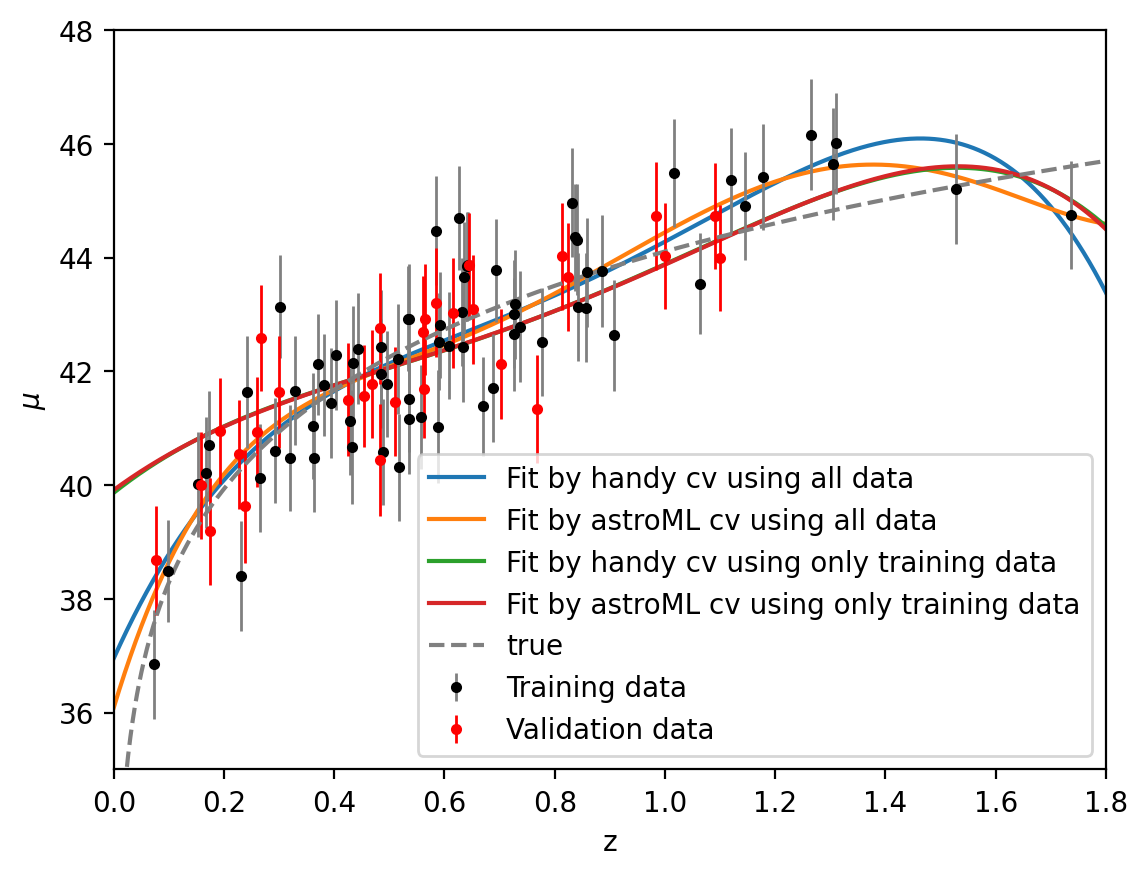

In [26]:
model_hand = PolynomialRegression(4)
model_func = PolynomialRegression(5)

model_hand.fit(z_sample[:,np.newaxis], mu_sample,dmu) # in this case dy is irrelevant because errors are homoscedastic
model_func.fit(z_sample[:,np.newaxis], mu_sample,dmu)
mu_fit_h = model_hand.predict(X_new[:,np.newaxis])
mu_fit_f = model_func.predict(X_new[:,np.newaxis])
plt.plot(X_new, mu_fit_h, label='Fit by handy cv using all data')
plt.plot(X_new, mu_fit_f, label='Fit by astroML cv using all data')

model_hand.fit(z_train[:,np.newaxis], y_train) # in this case dy is irrelevant because errors are homoscedastic
model_func.fit(z_train[:,np.newaxis], y_train)
mu_fit_h = model_hand.predict(X_new[:,np.newaxis])
mu_fit_f = model_func.predict(X_new[:,np.newaxis])
plt.plot(X_new, mu_fit_h, label='Fit by handy cv using only training data')
plt.plot(X_new, mu_fit_f, label='Fit by astroML cv using only training data')

plt.errorbar(z_train, mu_train, dmu[0:len(z_train)], fmt='.k', ecolor='gray', lw=1,label='Training data')
plt.errorbar(z_cv, mu_cv, dmu[0:len(z_cv)], fmt='.r', ecolor='red', lw=1, label='Validation data')

plt.plot(X_new, mu_true, '--', c='gray',label='true')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,1.8)
plt.ylim(35,48)
plt.legend(loc='lower right')

# Learning curves

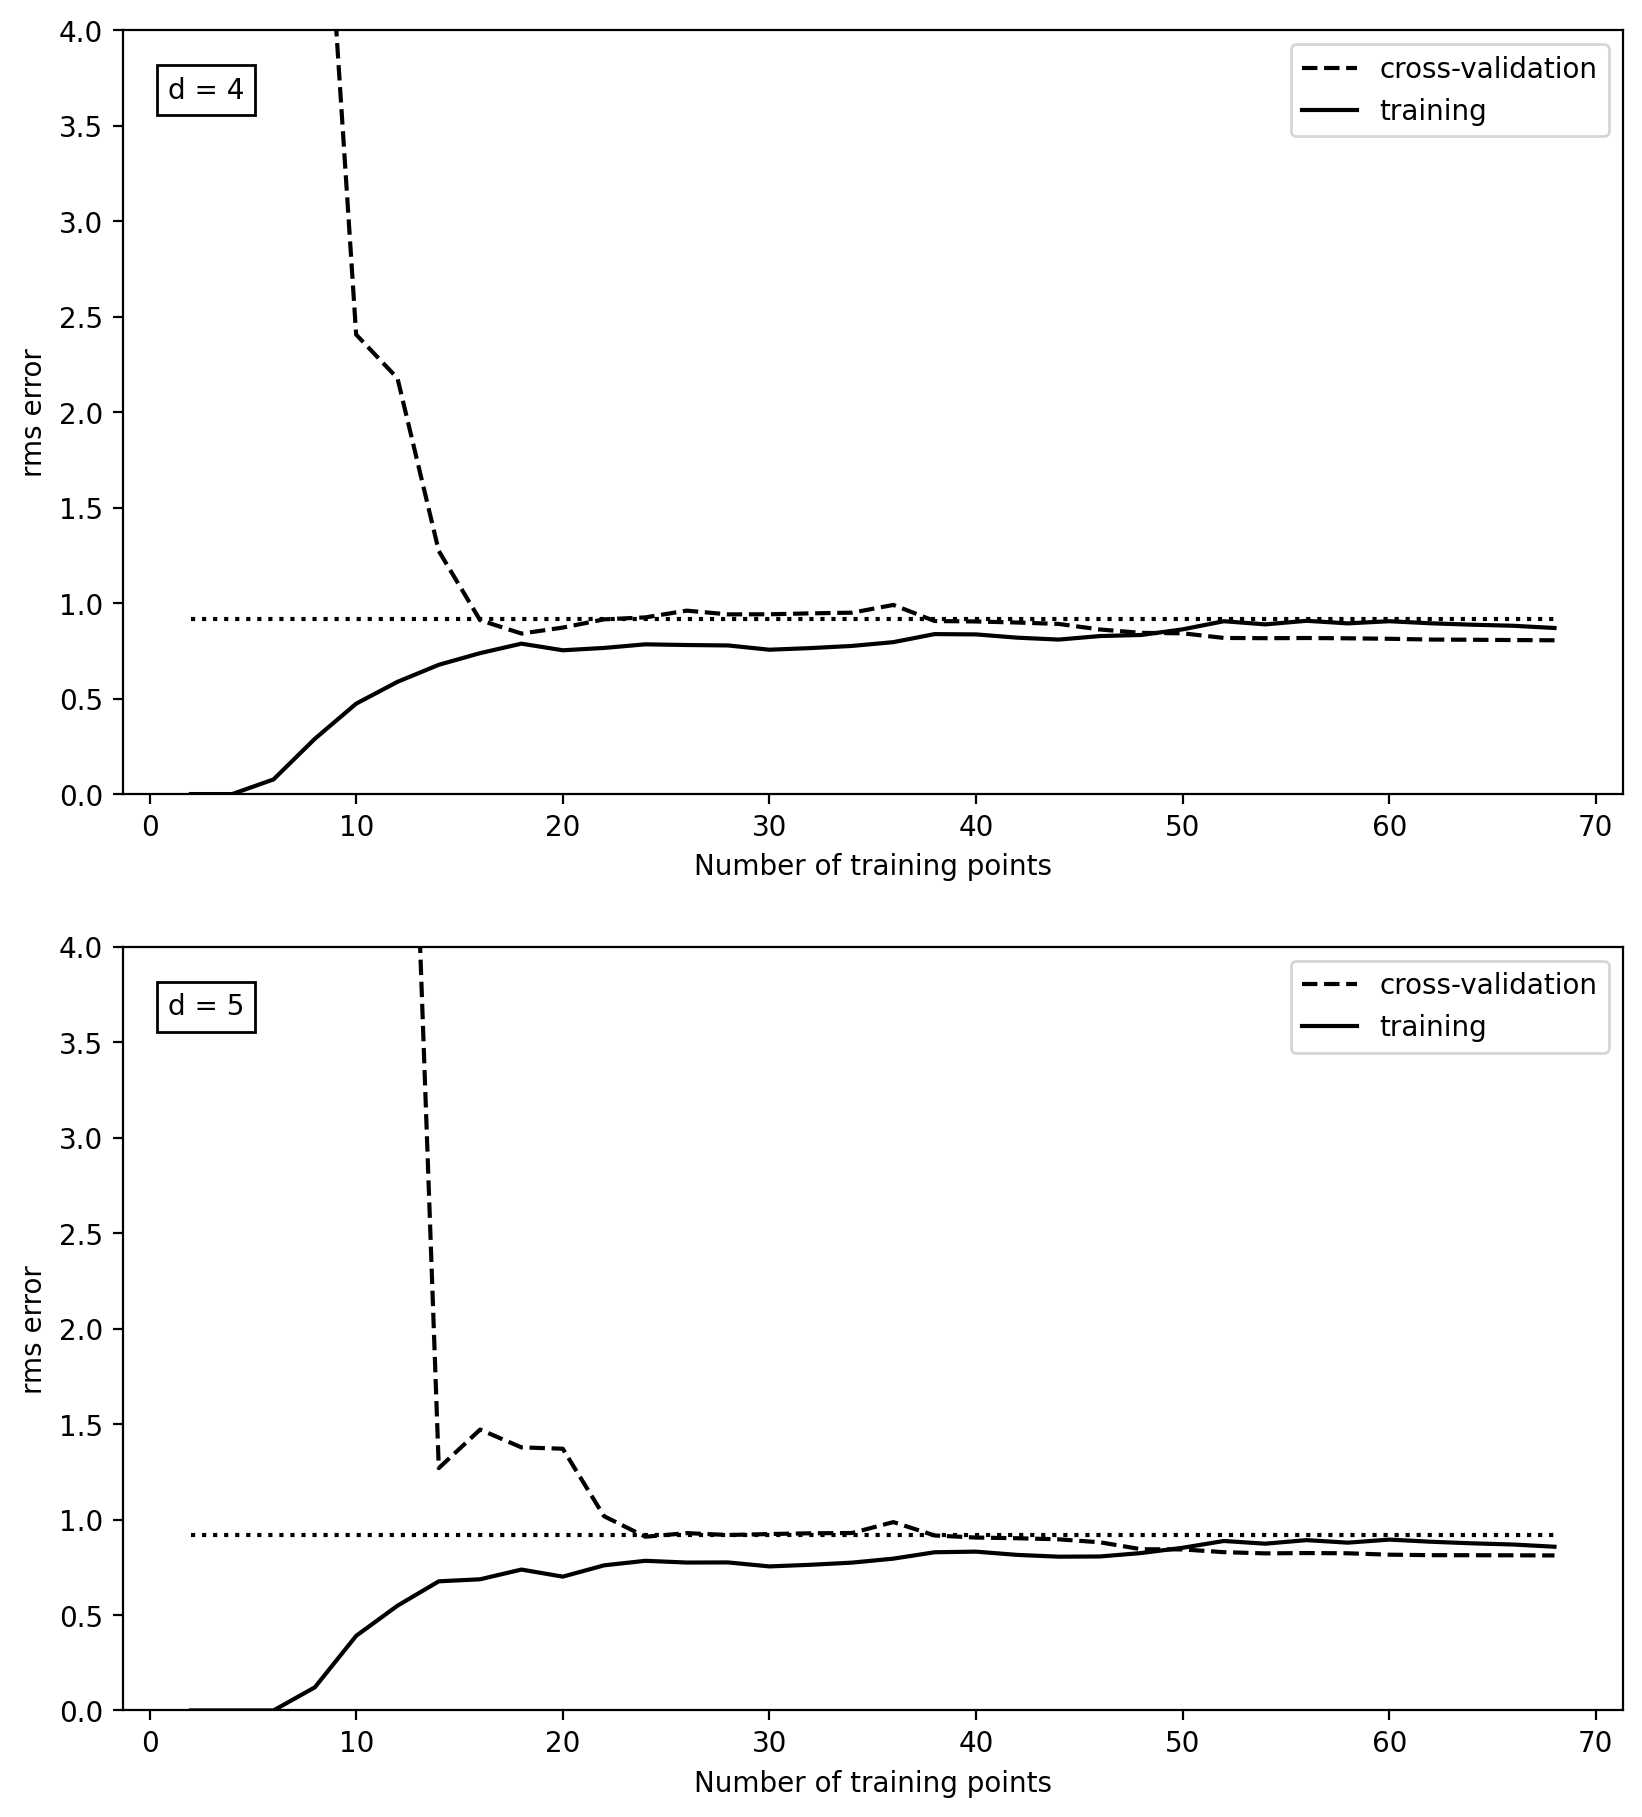

In [28]:
Nrange = np.arange(2, len(z_train), 2)

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.15, top=0.95)

for subplot, d in zip([211, 212], [4, 5]):
    ax = fig.add_subplot(subplot)
    training_err = np.zeros(Nrange.shape)
    crossval_err = np.zeros(Nrange.shape)

    for j, N in enumerate(Nrange):
        
        model = PolynomialRegression(d)
        model.fit(z_train[:N].reshape(-1,1),  mu_train[:N])
    
        y_train = model.predict(z_train[:N].reshape(-1,1))
        y_cv = model.predict(z_cv[:N].reshape(-1,1))
        
        training_err[j] = np.sqrt(np.sum((y_train[:N] - mu_train[:N]) ** 2)  / len(mu_train[:N]))
        crossval_err[j] = np.sqrt(np.sum((y_cv[:N] - mu_cv[:N]) ** 2) / len(mu_cv[:N]))

    ax.plot(Nrange, crossval_err, '--k', label='cross-validation')
    ax.plot(Nrange, training_err, '-k', label='training')
    ax.plot(Nrange, dmu[0] * np.ones(Nrange.shape), ':k')
    ax.legend(loc=1)
    ax.text(0.03, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='k', fc='w'))

    ax.set_ylim(0, 4)

    ax.set_xlabel('Number of training points')
    ax.set_ylabel('rms error')

plt.show()